<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '/Users/apple/Desktop/Python/Machine_learning/course6/week1'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
from datetime import datetime

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    ll = []
    path_to_csv_files += '/*'
    dict_sits = {}
    for target , csv_files in enumerate(glob(path_to_csv_files)):
        sites = pd.read_csv(csv_files).values

        for i in range(len(sites)):
            if sites[i][1] not in dict_sits:
                dict_sits[sites[i][1]] = len(dict_sits) + 1
            dt = datetime.strptime(sites[i][0], "%Y-%m-%d %H:%M:%S")
            sites[i] = [dict_sits[sites[i][1]]] + [dt]
            
        kk = 0
        while kk * window_size < len(sites):
            s = kk * window_size
            f = s + session_length
            l = sites[s : f]
            l2 = l[:, 1]
            session_timespan = [(l2[s + 1].second + l2[s + 1].minute * 60 + l2[s + 1].hour * 3600) - (l2[s].second + l2[s].minute * 60 + l2[s].hour * 3600) for s in range(len(l2) - 1)]
            session_timespan += (session_length - len(session_timespan) - 1) * [0]
            session_timespan += [sum(session_timespan)]
            start_hour = min([h.hour for h in l2])
            day_of_week = min([d.weekday() for d in l2])
            l1 = list(l[:, 0])
            l1 += (session_length - len(l1)) * [0] + session_timespan + [len(np.unique(l1))] + [start_hour] + [day_of_week] + [target + 1]
            ll += [l1]
            kk += 1
            
    s = []
    t = []
    for i in range(1, session_length + 1):
        s += ['site' + str(i)]
        if i != session_length:
            t += ['time_diff' + str(i)]
    h = s + t + ['session_timespan'] + ['unique_sites'] + ['start_hour'] + ['day_of_week'] + ['target']     
    data = pd.DataFrame.from_records(ll)
    data.columns = h
    return data
        

**Проверим функцию на игрушечном примере.**

In [5]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 24 elements

In [7]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [8]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [9]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'),
                    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 2.39 s, sys: 43.1 ms, total: 2.44 s
Wall time: 2.47 s


In [10]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,1
1,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,1
2,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,1
3,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,1
4,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [11]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'),
                    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 22.7 s, sys: 342 ms, total: 23.1 s
Wall time: 23.2 s


In [12]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,unique_sites,start_hour,day_of_week,target
0,1,1,2,3,1,2,1,3,4,5,1,1,1,4,0,1,0,49,0,57,5,8,4,1
1,3,6,7,4,5,5,8,9,10,10,0,0,26,1,10,73,0,1504,4,1618,8,8,4,1
2,5,11,1,1,1,1,9,5,3,1,1,10,1,5,16,56,1917,0,4,2010,5,8,4,1
3,1,1,12,12,13,12,12,1,14,1,1,0,1,0,118,420,1460,6,0,2006,4,9,4,1
4,1,1,15,1,16,17,16,17,18,15,4,3,0,1,0,1,0,1,0,10,5,9,4,1


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [13]:
new_features_10users = train_data_10users[train_data_10users.columns[10:]]
new_features_150users = train_data_150users[train_data_150users.columns[10:]]

In [14]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
id_name_dict = {1: 'Mary-Kate', 2: 'Ashley', 3: 'Lindsey', 4: 'Naomi', 5: 'Avril',
               6: 'Bob', 7: 'Bill', 8: 'John', 9: 'Dick', 10: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

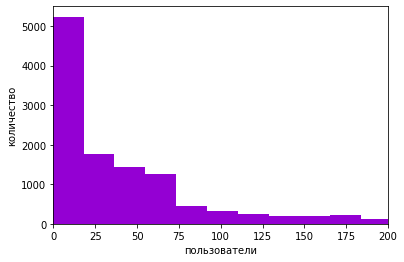

In [25]:
train_data_10users['session_timespan'].plot(kind='hist', xlim=(0,200),
                                                  bins=5000, color='darkviolet')
plt.xlabel('пользователи')
plt.ylabel('количество')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

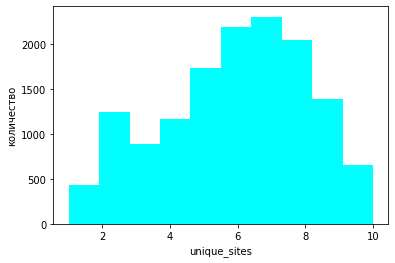

In [18]:
train_data_10users['unique_sites'].plot(kind = 'hist', color = 'aqua')
plt.xlabel('unique_sites')
plt.ylabel('количество')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

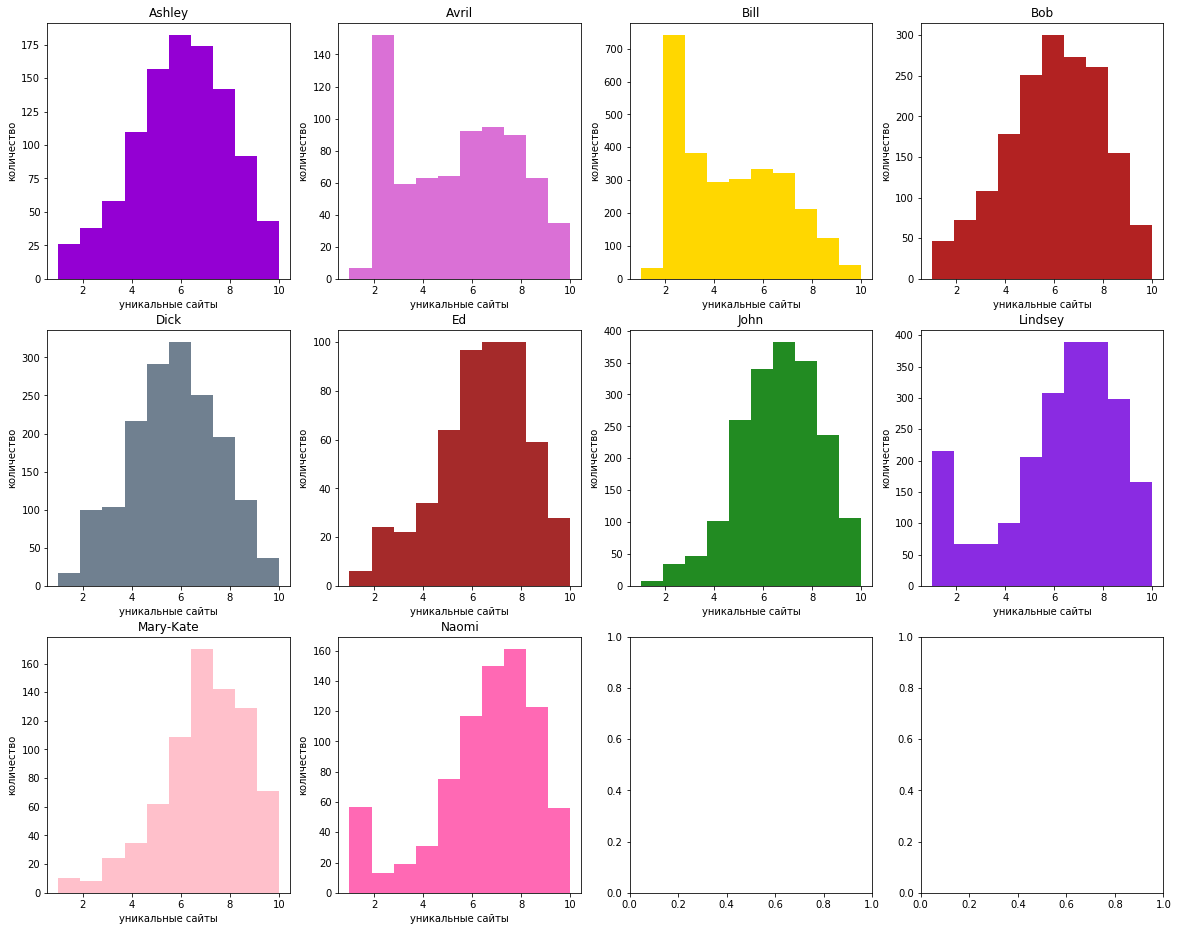

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 16))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])):
    axes[idx // 4][idx % 4].hist(sub_df['unique_sites'], color = color_dic[user])
    axes[idx // 4][idx % 4].set_title(user)
    axes[idx // 4][idx % 4].set_xlabel('уникальные сайты')
    axes[idx // 4][idx % 4].set_ylabel('количество')
    plt.subplots_adjust(wspace = 0.2, hspace = 0.2)

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

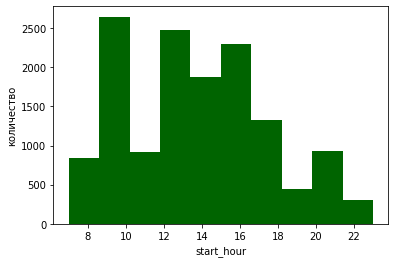

In [20]:
train_data_10users['start_hour'].plot(kind = 'hist', color = 'darkgreen')
plt.xlabel('start_hour')
plt.ylabel('количество')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

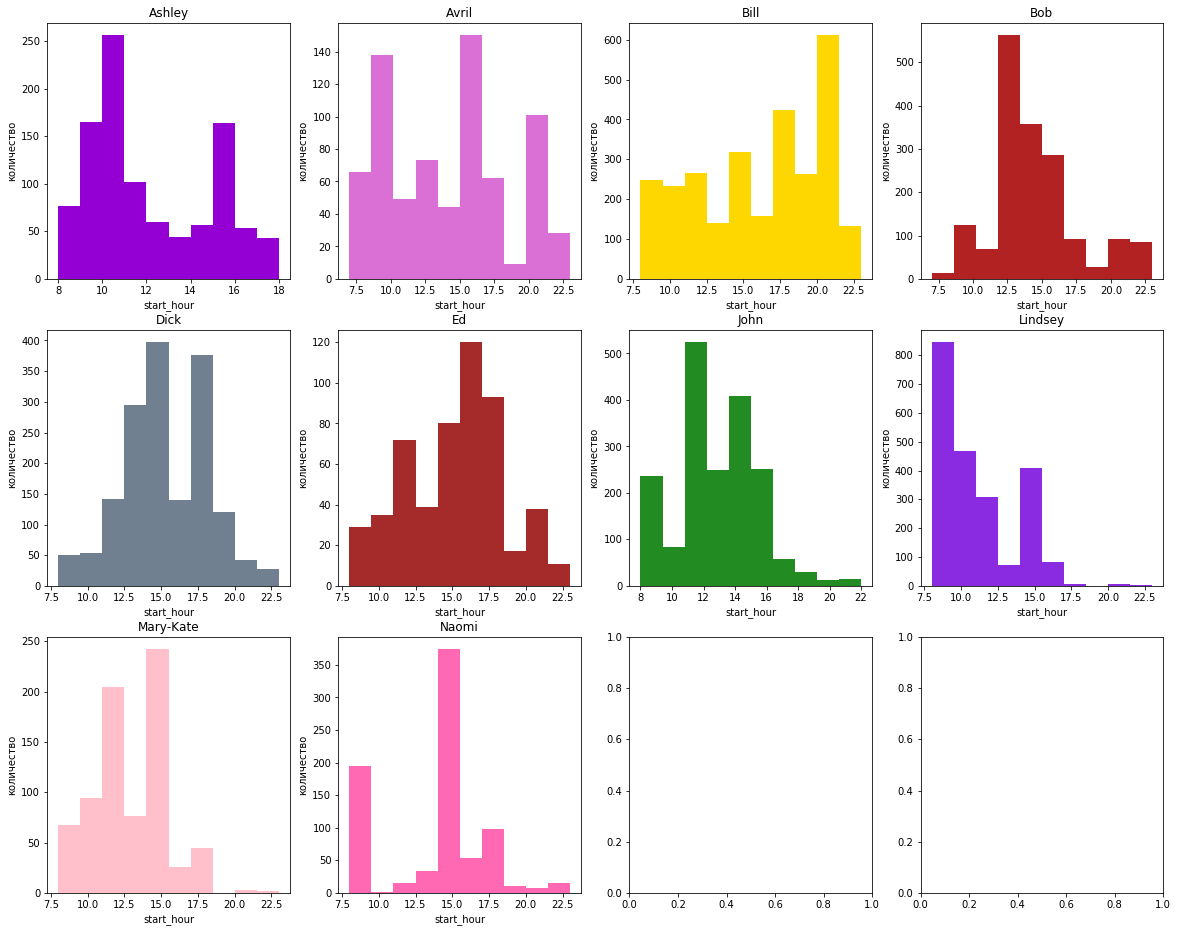

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 16))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])):
    axes[idx // 4][idx % 4].hist(sub_df['start_hour'], color = color_dic[user])
    axes[idx // 4][idx % 4].set_title(user)
    axes[idx // 4][idx % 4].set_xlabel('start_hour')
    axes[idx // 4][idx % 4].set_ylabel('количество')
    plt.subplots_adjust(wspace = 0.2, hspace = 0.2)

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

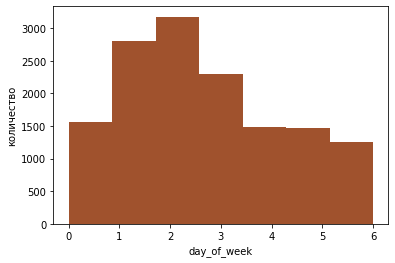

In [26]:
train_data_10users['day_of_week'].plot(kind = 'hist', color='sienna', bins=7)
plt.xlabel('day_of_week')
plt.ylabel('количество')
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

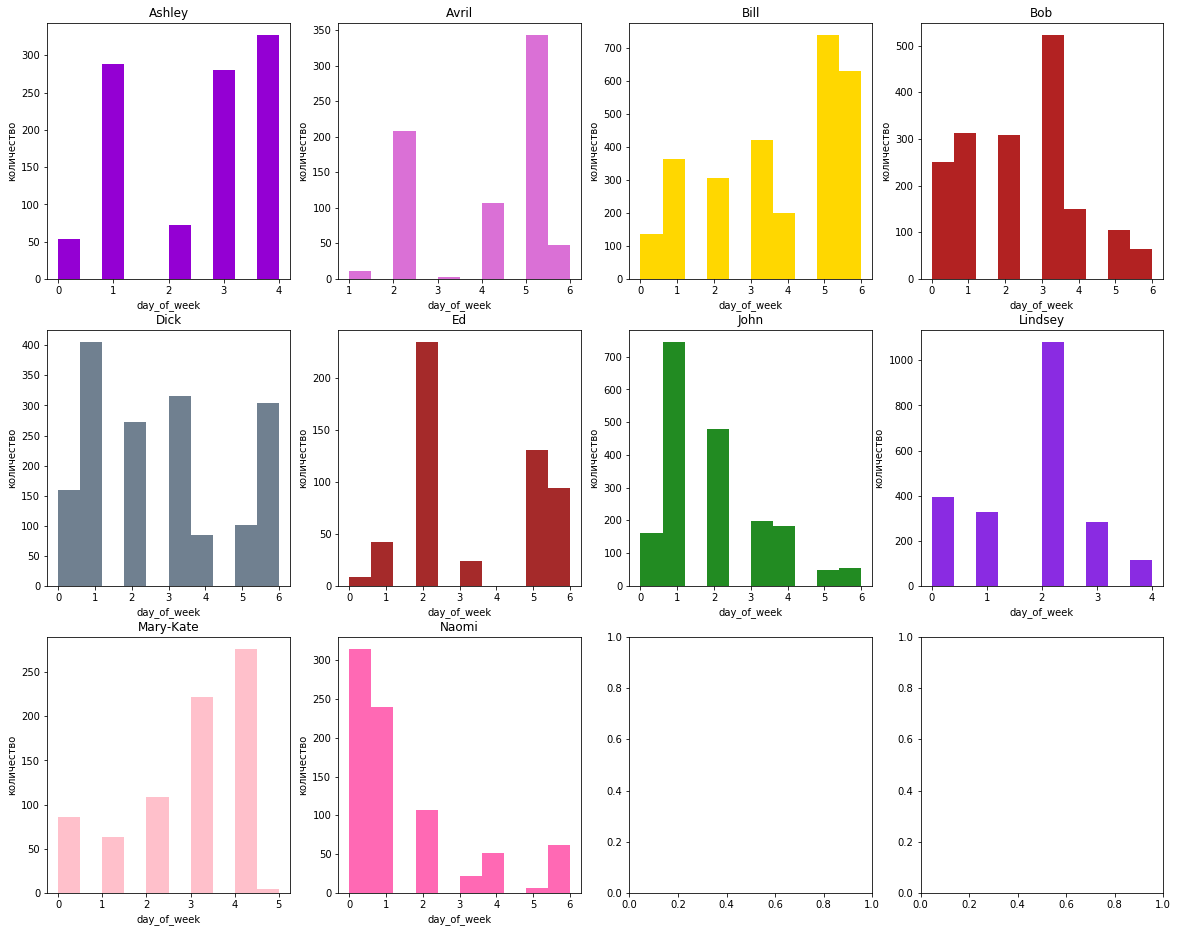

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 16))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])):
    axes[idx // 4][idx % 4].hist(sub_df['day_of_week'], color = color_dic[user])
    axes[idx // 4][idx % 4].set_title(user)
    axes[idx // 4][idx % 4].set_xlabel('day_of_week')
    axes[idx // 4][idx % 4].set_ylabel('количество')
    plt.subplots_adjust(wspace = 0.2, hspace = 0.2)

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Пользователей можно разделить на группы по форме распределений их признаков
* день недели - пользовательй модно раздеить на тех, кто совершается действяи только в будние или преимуществено в выходные
* час, соответсвующий началу - каждому пользователю соответсвует свое распределние: близкое к нормальному со средним в центре дня или скошенные вправо\влево, т.е. с медианой в начале или конце дня
* количество уникальных сайтов - большинство пользователй имеют распределние скошенное влево, т.е в большитсве случаев такие пользователи имеют близкое к максимальному количество уникальных сайтов. Но так же есть пара пользователей с болшим количеством значений уникальных сатов близким к 0.


1. Mary-Kate: часто заходит на одни и те же сайты, в основном проводит время в сети вечером -в 20-00 и в выходные. Очевидно, использует сеть для отдыха и общения.

2. Ashley: более или менее равномерно распределены уникальные сайты, но видимо, есть пара любимых. Пользуется сетью, видимо с работы - в основном утром и только в рабочие дни.

3. Lindsey: склонна разнообразить сайты,которые посещает, но и повторяется. В основном бывает в сети в середине дня, преимущественно в рабочие дни в начале недели.

4. Naomi: склонна разнообразить сайты,которые посещает, но и повторяется. Бывает в сети в основном в обеденное время. Бывает в сети каждый день, но в основном в конце недели.

5. Avril: склонен разнообразить сайты,которые посещает, но и повторяется. Бывает в сети в обед и в конце рабочего дня, всю неделю.

6. Bob: склонен разнообразить сайты,которые посещает, но и повторяется. Бывает в сети до 18-00, преимущественно утром и ближе к концу рабочего дня, только в рабочие дни.

7. Bill: больше разнообразит сайты, но, видимо, есть пара любимых. Бывает в сети утром и в середине дня. Присутствует в сети всю неделю, но в основном в пн и вт.

8. John: склонен разнообразить сайты,которые посещает. В основном бывает в сети в рабочее время и совсем немного вечером - в рабочие дни и немного в сб. Очевидно, в основном использует сеть на работе, и совсем немного для отдыха дома.

9. Dick: у него, судя по всему, много любимых сайтов. Присутствует в сети целый день. В основном бывает в сети в ср и выходные, никогда в пн. Скорее всего, использует сеть для отдыха.

10. Ed: склонен разнообразить сайты,которые посещает, но и повторяется. Присутствует в сети целый день, но более всего в конце рабочего дня. Также более всего бывает в ср и выходные и никогда в пт.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [23]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq_10users = pickle.load(f)  

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [24]:
for i in site_freq_10users:
    site_freq_10users[i] = site_freq_10users[i][1]
site_freq_10users    
mim = list(site_freq_10users.items())
mim_sorts = sorted(mim, key = lambda x : x[1], reverse = True)
l = np.array(mim_sorts[:10])

In [25]:
top10_freqs = l[:, 1]
top10_sites = l[:, 0]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).** 
ничего не сливается,  если сделать так, а смысл тот же

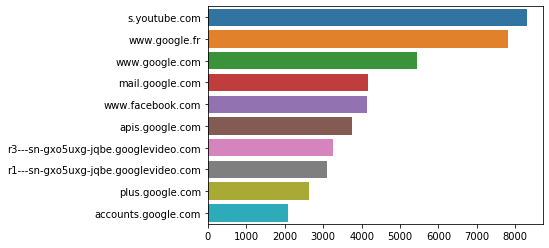

In [26]:
sns.barplot(top10_freqs, top10_sites)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [32]:
train_data_10users['session_timespan'].median()

33.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [33]:
train_data_10users['day_of_week'].median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [34]:
train_data_150users['start_hour'].median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [35]:
train_data_150users['unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [87]:
import collections
def day_time_id(x):
    x = int(x)
    if 7 <= x < 12:
        return 1
    if 12 <= x < 18:
        return 2
    if 18 <= x < 21:
        return 3
    else:
        return 4

In [100]:
# время суток
# индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
def feature_engineering(path_to_csv_files, session_length=10):
    ll = []
    path_to_csv_files += '/*'
    dict_sits = collections.defaultdict(int)
    
    for csv_files in glob(path_to_csv_files):
        sites = list(pd.read_csv(csv_files).site)
        for i in sites:
            dict_sits[i] += 1       
    top_15 = np.array(sorted(list(dict_sits.items()),  key = lambda x : x[1], reverse = True))
    
    for ind , csv_files in enumerate(glob(path_to_csv_files)):
        sites = list(pd.read_csv(csv_files).values)
        s = 0
        f = session_length 
        while s < len(sites):
            l = sites[s : f]
            time = [t[0][11: 13] for t in l]
            t = day_time_id(min(time))
            top = len(list(set(top_15[:15, 0]) & set(np.array(l)[:, 1])))
            ll += [[top] + [t]]
            s = f 
            f += session_length 
            
    data = pd.DataFrame.from_records(ll)
    data.columns = ['top' , 'time_id']
    return data
                    
feature_engineering(os.path.join(PATH_TO_DATA, '3users'))   

,top,time_id
0,8,1
1,2,2
2,3,1
3,5,1
4,3,2


In [94]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users')) 

In [95]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users')) 

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

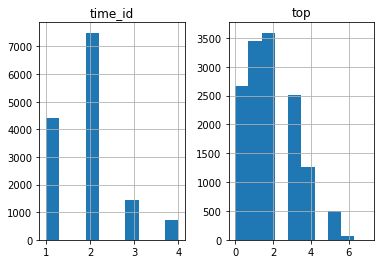

In [98]:
new_features_10users.hist()
plt.show()

time_id отвечает за время суток, чаще всего заходят с 12 по 18 часов

top индикаторы посещения 15 популярных сайтов, люди как правило посещают не больше 2 таких

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [101]:
selected_features_10users = new_features_10users 
selected_features_150users = new_features_150users

In [102]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 